In [100]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit

import recursive as sv
import pickle
from os import path
import pandas as pd

# Notebook Description

## This file contains analysis completed on May 10, 2021.

### The analysis includes:
#### * code to score two or three drumming signals based on a "smooth top-hat function"
#### * code to create the visualization panes of a group drumming distance's score
#### * populating the recursive datastructure olap2 and saving as olap3

In [2]:
data_path = path.join(*(['..']*3+['data','time_series_linear_interpolations']))
path.exists(data_path)

True

In [3]:
with open(path.join(data_path,'olap2.pickle'),'rb') as a:
    svdata = pickle.load(a)

In [4]:
list(svdata.sessions._data[1]._data[1]._data.keys())

['session', 'hr', 'drumming']

In [5]:
svdata.group_id[7]

1009

In [6]:
def get_group_id(svdata, gr_ind):
    return svdata.group_id[gr_ind]

def get_drumming_by_group(svdata,gr_ind):
    sample_drumming=sv.list_store(svdata.sessions.sample(3)).drumming[gr_ind].signal_4hz
    drumming_arr = np.array(sample_drumming.tolist())
    x = drumming_arr[0,0,:]
    y = drumming_arr[:,1,:]
    return x,y

In [7]:
def active_index_range(v1, v2,tol=0.02):
    # find the active time range
    l = v1.size
    start,stop = 0,l
    thres = np.finfo(float).eps #2.220446049250313e-16
    while True:
        w = np.vstack([v1[start:stop],v2[start:stop]])
        m = w.mean()
        new_thres = 0.2*m
        if (new_thres-thres)/thres < tol:
            break
        thres=new_thres
        both_active = (w[0,:]>thres) & (w[1,:]>thres)
        active_ind = np.arange(start,stop)[both_active]
        start = active_ind.min()
        stop = active_ind.max()
    return start, stop, thres

In [8]:
swish = lambda b: lambda x:  x * expit(x-b)
dist = lambda a: lambda x: a*x**2
damp = lambda k: lambda x: 2*expit(k*x)-1


In [9]:
score_func = lambda x: 1-damp(20)(swish(4)(dist(20)(x*2)))

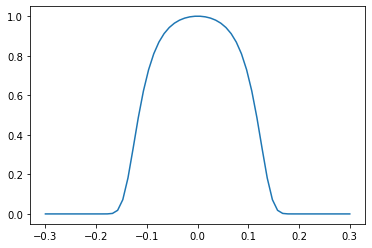

In [231]:
xp = np.linspace(-0.3, 0.3, 60)
plt.plot(xp, score_func(xp))

In [26]:
def score_drumming_signals(v1, v2, local=True):
    start, stop, _ = active_index_range(v1,v2)
    width = stop-start
    if width < 200: # 50 seconds
        raise ValueError("Cannot find active range. Found {} {}".format(start, stop))
    s = np.nan*np.ones_like(v1)
    s[start:stop] = score_func((v1-v2)[start:stop])
    if local:
        return s
    return np.nansum(s)/width

def score_drumming_triplets(v, local=True):
    return score_drumming_signals(v.min(axis=0), v.max(axis=0),local)


def mean_score(v1, v2):
    return score_drumming_signals(v1, v2, False)

def mean_score_triplet(v):
    return score_drumming_triplet(v, False)

In [11]:
x, y = get_drumming_by_group(svdata,8)
    

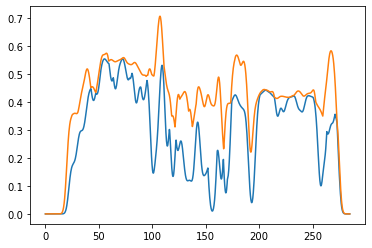

In [12]:
plt.plot(x,y.min(axis=0).T)
plt.plot(x,y.max(axis=0).T)

In [13]:
y.shape

(3, 1140)

In [15]:
score_drumming_triplets(y,False)

0.49464084580128387

In [93]:
def get_group_four_scores(gr_id):
    x, y = get_drumming_by_group(svdata,gr_ind)
    group_id = get_group_id(svdata,gr_ind)
    ret = {"group_id": group_id}
    if y.shape[0]<3:
        print("This group has only {} drumming signals".format(y.shape[0]))
        return
    group_score = score_drumming_triplets(y,False)
    combs = [(0, 1), (0, 2), (1, 2)]
    pair_scores = [score_drumming_signals(*y[pair,:],False) for pair in combs]
    ret.update({f"comb{i}_score": p for (i,p) in enumerate(pair_scores)})
    ret.update({"group_score": group_score})
    return ret

In [222]:
def map_at_max(x ,y):
    ymin, ymax = np.abs(y.min(axis=0)), np.abs(y.max(axis=0))
    start, stop, _ = active_index_range(ymin,ymax)

    ret = np.nan*np.ones_like(y)
    at_max = y.argmax(axis=0)
    for i, r in enumerate(at_max[start:stop],start):
        ret[r,i] = 1
    return ret
    

In [217]:
def draw_group_pairs(gr_ind, draw_triplet_score=True):
    combs = [(0, 1), (0, 2), (1, 2)]
    colors = ['C0','C2','C4']
    x, y = get_drumming_by_group(svdata,gr_ind)
    if y.shape[0]<3:
        print("This group has only {} drumming signals".format(y.shape[0]))
        return
    if draw_triplet_score:
        fig,axs = plt.subplots(2,2,sharex=True, sharey=True, figsize=(11,8))
        axs = axs.reshape(-1)
        group_ax = axs[0]
        axs = axs[1:]
        y_min, y_max = y.min(axis=0), y.max(axis=0)

    else:
        fig,axs = plt.subplots(1,3,sharex=True, sharey=True, figsize=(16,4))
        axs = axs.reshape(-1)            


    group_score = score_drumming_triplets(y,False)
    st = f"Group {get_group_id(svdata,gr_ind)} " 
    st += f"(group score {group_score:.3f})"
    fig.suptitle(st,fontsize=18)
    for ax,pair in zip(axs,combs):
        y_pair = y[pair,:]
        curr_colors = colors[pair[0]], colors[pair[1]]
        if draw_triplet_score:
            ax.fill_between(x,y_min,y_max,color='C8',alpha=0.4)
        ax.plot(x,y_pair[0,:],color=curr_colors[0])
        ax.plot(x,y_pair[1,:],color=curr_colors[1])
        ax.plot(x,score_drumming_signals(*y_pair)*0.6+0.4,color=(0.2,0.2,0.2,0.3))
        ax.plot(x,[0.4]*x.shape[0],'--',color=(0.2,0.2,0.2,0.3))
        
        #ax.plot(x,score_drumming_signals(*y_pair),color=(0.2,0.2,0.2,0.3))
        ax.set_title("mean_score {:.3f}".format(mean_score(*y_pair)))
        
    if draw_triplet_score:
        group_ax.plot(x,y_min,'C5')
        group_ax.plot(x,y_max,'C5')
        group_ax.fill_between(x,y_min,y_max,color='C8',alpha=0.4)

        group_ax.plot(x,score_drumming_signals(y_min,y_max)*0.6+0.4,color='#17becf', alpha=0.3)
        group_ax.plot(x,[0.4]*x.shape[0],'--',color=(0.2,0.2,0.2,0.3))
        #ax.plot(x,score_drumming_signals(*y_pair),color=(0.2,0.2,0.2,0.3))
        group_ax.set_title("group_score {:.3f}".format(group_score),color='#17becf')
        mamax = map_at_max(x,y)
        mamin = map_at_max(x,-y)
        
        for i, mam_row in enumerate(mamax):
            group_ax.plot(x,mam_row*y.max()+i*0.02,'.', color=colors[i],markersize=0.4)

        for i, mam_row in enumerate(mamin):
            group_ax.plot(x,-mam_row*0.03-i*0.02,'.', color=colors[i],markersize=0.4)
        

In [98]:
def get_group_four_scores(gr_ind):
    x, y = get_drumming_by_group(svdata,gr_ind)
    group_id = get_group_id(svdata,gr_ind)
    ret = {"group_id": group_id}
    if y.shape[0]<3:
        print("This group has only {} drumming signals".format(y.shape[0]))
        return
    group_score = score_drumming_triplets(y,False)
    combs = [(0, 1), (0, 2), (1, 2)]
    pair_scores = [score_drumming_signals(*y[pair,:],False) for pair in combs]
    ret.update({f"comb{i}_score": p for (i,p) in enumerate(pair_scores)})
    ret.update({"mean_score": sum(pair_scores)/3, "group_score": group_score})
    return ret

In [146]:
get_group_four_scores(4)

{'group_id': 1006,
 'comb0_score': 0.643512745719078,
 'comb1_score': 0.7305187130973081,
 'comb2_score': 0.6594963146126265,
 'mean_score': 0.6778425911430043,
 'group_score': 0.47708332421240923}

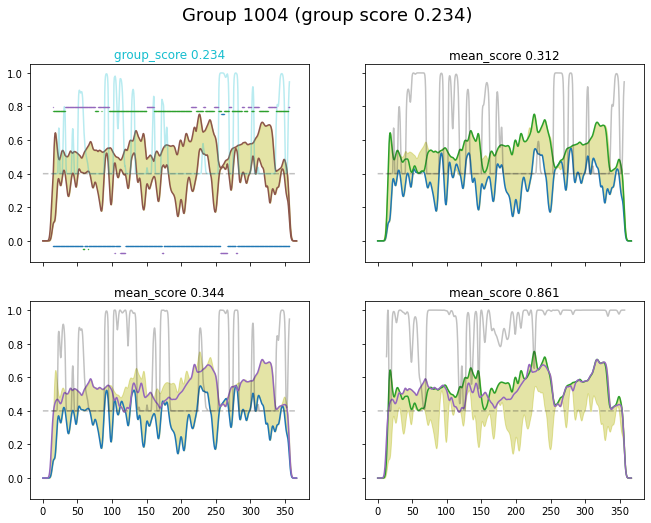

In [229]:
draw_group_pairs(2,True)

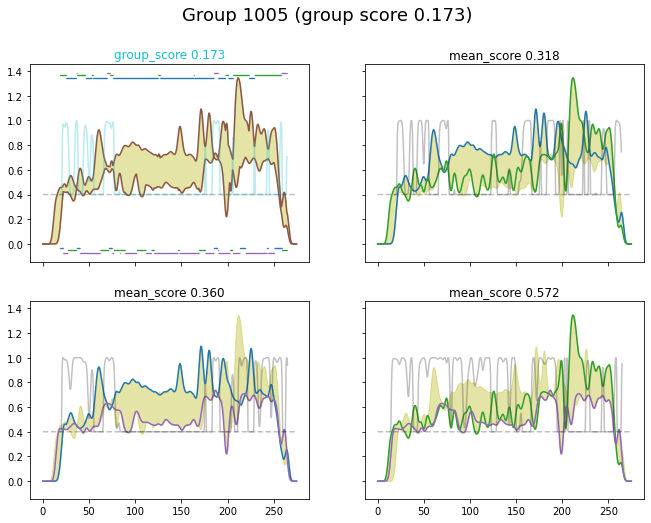

In [230]:
draw_group_pairs(3,True)

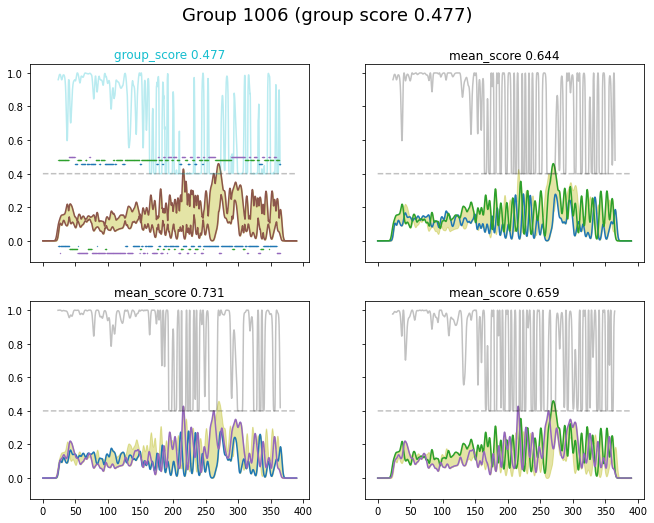

In [223]:
draw_group_pairs(4,True)

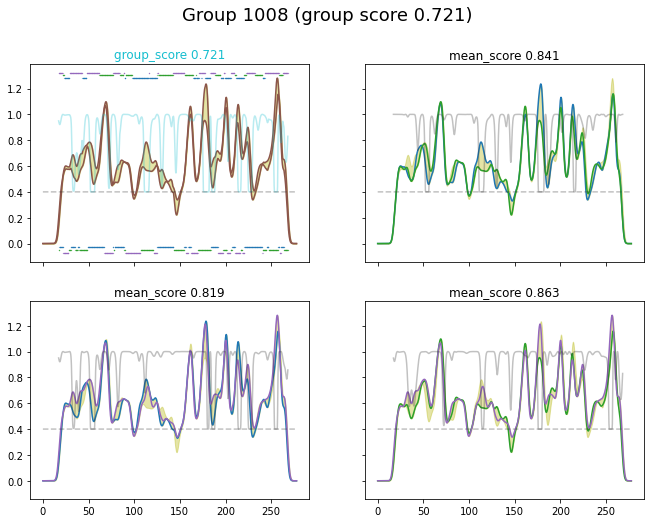

In [224]:
draw_group_pairs(6,True)

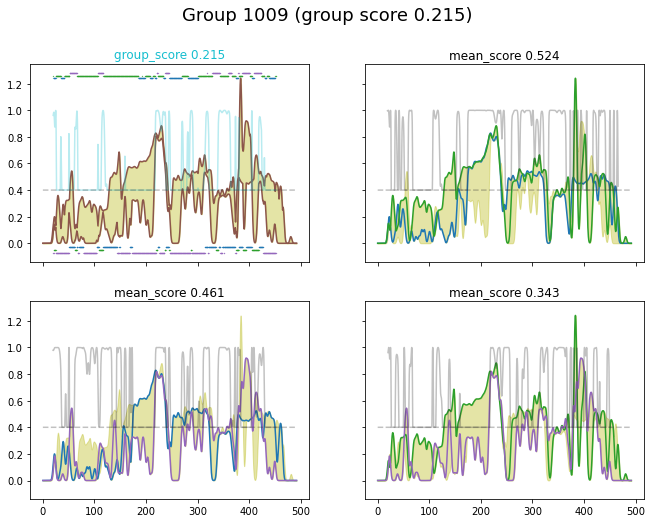

In [225]:
draw_group_pairs(7,True)

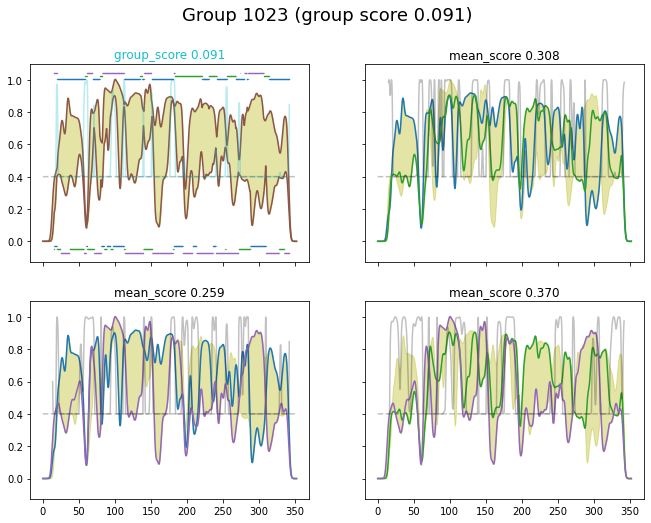

In [226]:
draw_group_pairs(19,True)

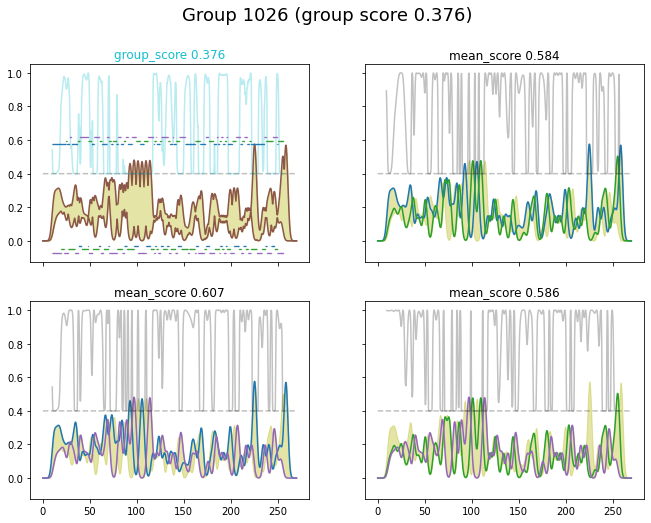

In [227]:
draw_group_pairs(22,True)

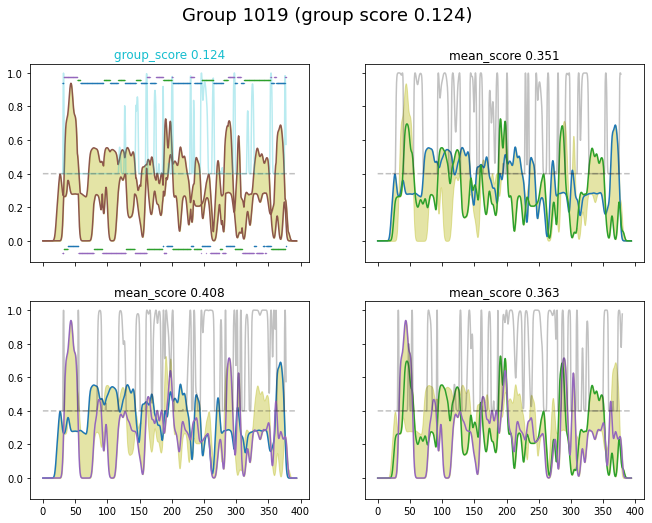

In [228]:
draw_group_pairs(16,True)

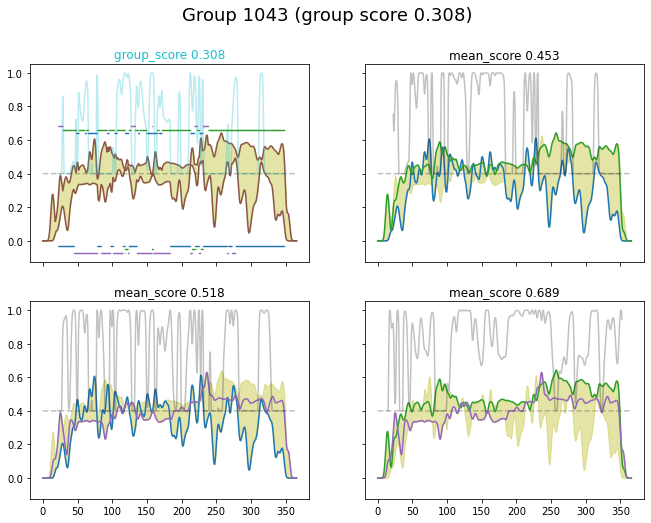

In [233]:
draw_group_pairs(39,True)

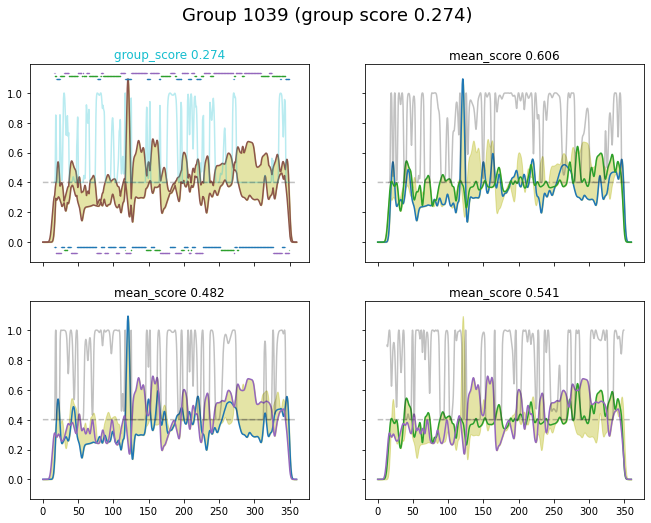

In [234]:
draw_group_pairs(35,True)

In [172]:
def time_at_max_and_min(gr_ind):
    x, y = get_drumming_by_group(svdata,gr_ind)
    y_min, y_max = y.min(axis=0,keepdims=True), y.max(axis=0,keepdims=True)
    start, stop, _ = active_index_range(y_min.squeeze(),y_max.squeeze())
    cut = lambda t: t[:,start:stop]
    y_min = cut(y_min)
    y_max = cut(y_max)
    y = cut(y)
    ln = stop-start
    def y_at(ym):
        y_at_m = y==ym
        y_at_m = y_at_m / y_at_m.sum(axis=0)
        y_at_m = y_at_m.sum(axis=1)/ln
        return y_at_m
    return y_at(y_min), y_at(y_max)

In [187]:
r = np.ones((3,10))

In [188]:
r

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [189]:
r[[0,1,2,2,1,0,0,1,2,2],:]=3
r

array([[3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.],
       [3., 3., 3., 3., 3., 3., 3., 3., 3., 3.]])

In [185]:
a

True

In [175]:
[np.round(time_at_max_and_min(i)[0],2) for i in range(10)]

[array([0.43, 0.23, 0.33]),
 array([0.34, 0.4 , 0.26]),
 array([0.92, 0.01, 0.07]),
 array([0.12, 0.25, 0.62]),
 array([0.5 , 0.16, 0.34]),
 array([0.23, 0.02, 0.75]),
 array([0.4 , 0.34, 0.26]),
 array([0.33, 0.12, 0.54]),
 array([0.19, 0.25, 0.56]),
 array([0.31, 0.17, 0.52])]

In [179]:
[np.round(time_at_max_and_min(i)[1],2) for i in range(10)]

[array([0.24, 0.37, 0.39]),
 array([0.28, 0.25, 0.47]),
 array([0.01, 0.64, 0.35]),
 array([0.65, 0.3 , 0.06]),
 array([0.2 , 0.54, 0.26]),
 array([0.12, 0.83, 0.05]),
 array([0.28, 0.31, 0.41]),
 array([0.24, 0.56, 0.2 ]),
 array([0.44, 0.35, 0.21]),
 array([0.34, 0.43, 0.23])]

In [157]:
ymn = y.min(axis=0,keepdims=False)

In [161]:
sum(((ymn==y).sum(axis=0))==2)

3

In [103]:
len(svdata.group_id._data)

48

In [105]:
df = pd.DataFrame(data=[get_group_four_scores(i) for i in range(48)])

(array([9., 6., 8., 4., 5., 3., 4., 2., 1., 6.]),
 array([0.05421323, 0.12431241, 0.19441159, 0.26451076, 0.33460994,
        0.40470912, 0.4748083 , 0.54490747, 0.61500665, 0.68510583,
        0.75520501]),
 <BarContainer object of 10 artists>)

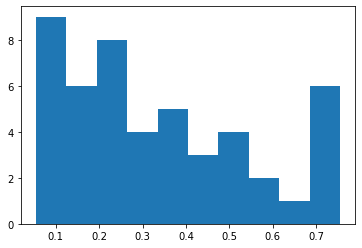

In [106]:
plt.hist(df.group_score)

(array([3., 7., 5., 6., 5., 7., 5., 2., 1., 7.]),
 array([0.2512421 , 0.31277524, 0.37430838, 0.43584152, 0.49737466,
        0.5589078 , 0.62044094, 0.68197408, 0.74350722, 0.80504036,
        0.86657351]),
 <BarContainer object of 10 artists>)

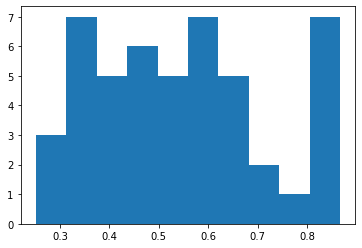

In [108]:
plt.hist(df.mean_score)

(array([[3., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [5., 2., 0., 0., 0., 0., 0., 0., 0., 0.],
        [1., 4., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 6., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 2., 3., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 4., 2., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 1., 3., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 6.]]),
 array([0.2512421 , 0.31277524, 0.37430838, 0.43584152, 0.49737466,
        0.5589078 , 0.62044094, 0.68197408, 0.74350722, 0.80504036,
        0.86657351]),
 array([0.05421323, 0.12431241, 0.19441159, 0.26451076, 0.33460994,
        0.40470912, 0.4748083 , 0.54490747, 0.61500665, 0.68510583,
        0.75520501]),
 <matplotlib.collections.QuadMesh at 0x7f9131051410>)

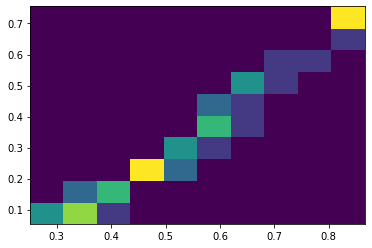

In [109]:
plt.hist2d(df.mean_score, df.group_score)

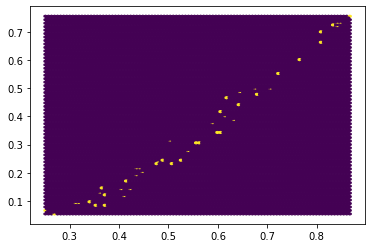

In [110]:
plt.hexbin(df.mean_score, df.group_score)

In [111]:
df['min_score']=[min(r.comb0_score, r.comb1_score, r.comb2_score) for r in df.itertuples()]

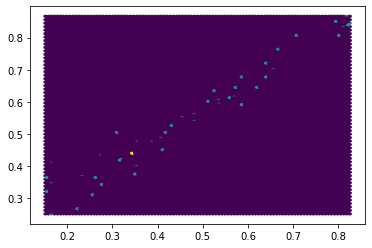

In [113]:
plt.hexbin(df.min_score, df.mean_score)

In [122]:
def get_group_scores_svdata(gr_ind):
    x, y = get_drumming_by_group(svdata,gr_ind)
    if y.shape[0]<3:
        print("This group has only {} drumming signals".format(y.shape[0]))
        return
    group_score = score_drumming_triplets(y,False)
    combs = [(0, 1), (0, 2), (1, 2)]
    pair_scores = [score_drumming_signals(*y[pair,:],False) for pair in combs]
    return {"drumming_pair_scores": pair_scores, "drumming_mean_score": sum(pair_scores)/3,  "drumming_group_score": group_score}

In [117]:
len(svdata.drumming.sample(3))

{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 103, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 102, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'participant_id': 101, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
)
}
{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 103, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 102, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'participant_id': 101, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
)
}
{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 107, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 108, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'parti

{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 202, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 198, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'participant_id': 200, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
)
}
{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 205, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 204, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'participant_id': 203, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
)
}
{'sessions': list_store (dict_store {'drummer': 43, 'participant_id': 205, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 45, 'participant_id': 204, 'signal_4hz': [[0.0, 0.25, 0.5, 0.75, 1.0, 1.25, 1.5, ...}
, dict_store {'drummer': 48, 'parti

48

In [119]:
i=0
list(svdata._data[i]._data['sessions'][3]._data.keys())

['session', 'hr', 'drumming', 'coupling_2d']

In [120]:
svdata._data[i]._data['sessions'][3]._data['coupling_2d']

dict_store {'remez': [0.30865236229458465, 1.5412726626724513]}

In [123]:
for gr_ind in range(48):
    svdata._data[gr_ind]._data['sessions'][3]._data['drum_signal_scores'] = sv.dict_store(get_group_scores_svdata(gr_ind))

In [126]:
with open(path.join(data_path,'olap3.pickle'),'wb') as a:
    pickle.dump(svdata,a)

In [127]:
import yaml

In [138]:
import yaml
yml_file =path.join(data_path,'readme.yaml') 
if path.exists(yml_file):
    print("warning! file already exists!")
else:
    
    with open(yml_file, 'wt') as a:
        yaml.dump({
            "olap.pickle": ["heart rate data", None],
            "olap2.pickle": ["added drumming data", None],
            "olap3.pickle": ["added drum signal coupling scores", "coupling_analysis/score_drumming_triplets.ipynb"]
        }, a, allow_unicode=True)

warning! file already exists!


In [136]:
!ls -lh ../../../data/time_series_linear_interpolations 

total 62M
-rw-rw-r-- 1 siegman siegman 2.2M Mar 18 10:31 baseline_raw.json
-rw-rw-r-- 1 siegman siegman 2.1M Mar 18 10:27 freestyle_raw.json
-rw-rw-r-- 1 siegman siegman  22M Apr 28 14:42 olap2.pickle
-rw-rw-r-- 1 siegman siegman  22M May  9 16:09 olap3.pickle
-rw-rw-r-- 1 siegman siegman  15M Apr 26 16:54 olap.pickle
-rw-rw-r-- 1 siegman siegman  181 May  9 16:20 readme.yaml
